# Automobiles and Customer Satisfaction

**Goal: Identify autombile customer satisfaction using association rules, K-Means clustering, and K-Nearest neighbors classification.**  

Datasets:  
    [car data](https://raw.githubusercontent.com/crosstrack10/data-science-projects/main/datasets/car_evaluation_dataset.csv)  
    [binary car data](https://raw.githubusercontent.com/crosstrack10/data-science-projects/main/datasets/car_evaluation_dataset_logical.csv)

I will begin the data exploration phase by limiting number of threads used and importing essential libraries for exploration.

In [1]:
# setting number of threads to six
import os
os.environ["OMP_NUM_THREADS"] = "6"

# importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%config Completer.use_jedi = False

In [2]:
# reading in car dataset from github repository
url = "https://raw.githubusercontent.com/crosstrack10/data-science-projects/main/datasets/car_evaluation_dataset.csv"
car_data = pd.read_csv(url)

In [3]:
# shuffling dataset
car_data = car_data.iloc[:, 1:].sample(frac=1).reset_index(drop=True)

In [4]:
# first five rows
car_data.head()

,Purchase Price,Maintenance Costs,Doors,Persons,Luggae Boot,Safety,Rating
0,vhigh,vhigh,3,2,big,med,unacc
1,med,med,4,more,med,med,acc
2,low,high,2,4,big,low,unacc
3,high,high,3,2,big,med,unacc
4,low,high,2,more,med,med,acc


In [5]:
# general variable info
car_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1728 entries, 0 to 1727
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Purchase Price     1728 non-null   object
 1   Maintenance Costs  1728 non-null   object
 2   Doors              1728 non-null   object
 3   Persons            1728 non-null   object
 4   Luggae Boot        1728 non-null   object
 5   Safety             1728 non-null   object
 6   Rating             1728 non-null   object
dtypes: object(7)
memory usage: 94.6+ KB


There are no null values present in the dataset. Also, all of the columns are object types. Let's count the values using barplots to make sure they were imported as the correct data type. It will also give us a chance to look at the distribution among columns.

In [6]:
# retrieving general statistics for numerical variables
car_data.describe()

,Purchase Price,Maintenance Costs,Doors,Persons,Luggae Boot,Safety,Rating
count,1728,1728,1728,1728,1728,1728,1728
unique,4,4,4,3,3,3,4
top,vhigh,vhigh,5more,more,big,high,unacc
freq,432,432,432,576,576,576,1210


All of the columns have 3-4 unique values. Most of them seem to be ordinal variables. Let's make sure that's the case.

In [7]:
# storing column names
col_names = car_data.columns

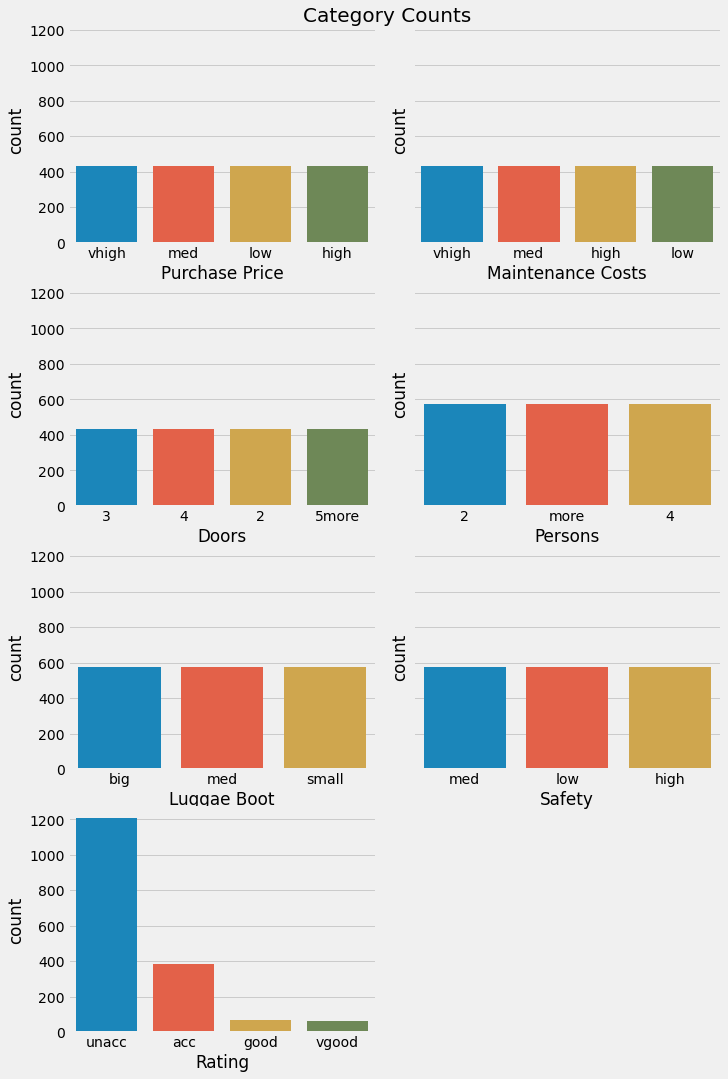

In [8]:
# counting variables using barplots
plt.style.use("fivethirtyeight")
fig, axes = plt.subplots(4, 2, figsize=(10, 15), sharey=True) # creates figure and axes
fig.tight_layout() # removes extra whitespaces
fig.subplots_adjust(top=0.97)
fig.suptitle("Category Counts", fontsize=20); # spacing out title

# adding plots to subplots
sns.countplot(ax=axes[0, 0], data=car_data, x=col_names[0]);
sns.countplot(ax=axes[0, 1], data=car_data, x=col_names[1]);
sns.countplot(ax=axes[1, 0], data=car_data, x=col_names[2]);
sns.countplot(ax=axes[1, 1], data=car_data, x=col_names[3]);
sns.countplot(ax=axes[2, 0], data=car_data, x=col_names[4]);
sns.countplot(ax=axes[2, 1], data=car_data, x=col_names[5]);
sns.countplot(ax=axes[3, 0], data=car_data, x=col_names[6]);
axes[-1, -1].axis("off");

Yes, they all seem to be ordinal variables. I am not sure how this will affect the K-Means and K-Nearest Neighbors classificaiton algorithms. It might be hard to visualize clusters using K-Means. All of the columns have a fixed number of unique values. A K-Nearest Neighbors classifier might overfit the data due to possibly having seen most of the holdout data during training.

### Association Rules

In this section, I will use association rules on a binary format version of the car dataset. The first goal is to determine three rules with two items with the strongest support. The second goal is similar to the first one, but instead of finding three rules with two items, I will find three rules with three items.

In [9]:
# reading in binary car dataset from github repository
url = "https://raw.githubusercontent.com/crosstrack10/data-science-projects/main/datasets/car_evaluation_dataset_logical.csv"
binary_car_data=pd.read_csv(url).sample(frac=1).reset_index(drop=True)

In [10]:
# retrieving general statistics for numerical variables
binary_car_data.describe()

,2door,2person,3door,4door,4person,5moredoor,acc,bigluggage,good,highmaint,...,medluggage,medmaint,medpurchase,medsafety,moreperson,smallluggage,unacc,vgood,vhighmaint,vhighpurchase
count,1728.000000,1728.000000,1728.000000,1728.000000,1728.000000,1728.000000,1728.000000,1728.000000,1728.000000,1728.000000,...,1728.000000,1728.000000,1728.000000,1728.000000,1728.000000,1728.000000,1728.000000,1728.000000,1728.000000,1728.000000
mean,0.250000,0.333333,0.250000,0.250000,0.333333,0.250000,0.222222,0.333333,0.039931,0.250000,...,0.333333,0.250000,0.250000,0.333333,0.333333,0.333333,0.700231,0.037616,0.250000,0.250000
std,0.433138,0.471541,0.433138,0.433138,0.471541,0.433138,0.415860,0.471541,0.195853,0.433138,...,0.471541,0.433138,0.433138,0.471541,0.471541,0.471541,0.458289,0.190320,0.433138,0.433138
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,0.250000,1.000000,0.250000,0.250000,1.000000,0.250000,0.000000,1.000000,0.000000,0.250000,...,1.000000,0.250000,0.250000,1.000000,1.000000,1.000000,1.000000,0.000000,0.250000,0.250000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [11]:
# importing apriori model and association rules
from mlxtend.frequent_patterns import apriori, association_rules

# builiding the model
freq_items = apriori(binary_car_data, min_support=0.05, use_colnames=True)

# collecting rules in a dataframe
rules = association_rules(freq_items, metric="lift", min_threshold=0.05)
rules = rules.sort_values(["support", "confidence"], ascending=[False, False])

In [12]:
# top 3 single item frequent item sets
rules.head(3)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
66,(2person),(unacc),0.333333,0.700231,0.333333,1.000000,1.428099,0.099923,inf
368,(lowsafety),(unacc),0.333333,0.700231,0.333333,1.000000,1.428099,0.099923,inf
67,(unacc),(2person),0.700231,0.333333,0.333333,0.476033,1.428099,0.099923,1.272345


The top three rules with the strongest support with two items reveal some interesting findings. All three rules have the support of about 0.33. A two person vehicle antecedent and a consequent unacceptable rating have the confidence of 1.00. The same can be said for a low safety vehicle and a consequent unacceptable rating. An antecedent unacceptable rating and a consequent two person vehicle have the confidence of about 0.48. From a business perspective, these findings may indicate unacceptable car ratings are usually associated with two person and low safety vehicles. These rules might make a business purchase fewer two person and low safety vehicles. 

In [13]:
# top 3 double item frequent item sets
rules.loc[rules["antecedents"].astype(str).str.count(",") == 1].head(3)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
518,"(bigluggage, 2person)",(unacc),0.111111,0.700231,0.111111,1.0,1.428099,0.033308,inf
537,"(2person, highsafety)",(unacc),0.111111,0.700231,0.111111,1.0,1.428099,0.033308,inf
554,"(2person, lowsafety)",(unacc),0.111111,0.700231,0.111111,1.0,1.428099,0.033308,inf


These three rules with three items reveal two person vehicles are still associated with unacceptable ratings. The confidence level for each rules is 1.0. The biggest issue with two person vehicles is room capicity and safety to a degree.

### K-Means Clustering

This section will include a K-Means clustering classification algorithm. The goal is to find patterns around unacceptable ratings and non-unacceptable ratings.

In [14]:
# converting categorical variable to numerical
from sklearn import preprocessing

label = preprocessing.LabelEncoder()
X = pd.DataFrame() 

for i in car_data.columns :
  X[i] = label.fit_transform(car_data[i])

y = X.Rating
X = X.iloc[:, :-1]

In [15]:
# first five rows
X.head()

,Purchase Price,Maintenance Costs,Doors,Persons,Luggae Boot,Safety
0,3,3,1,0,0,2
1,2,2,2,2,1,2
2,1,0,0,1,0,1
3,0,0,1,0,0,2
4,1,0,0,2,1,2


I decided to only include a number of clusters range from 1-7 to minimize overfitting the data. It will also help from a computational performance aspect.

In [16]:
# importing GridSearchCv for parameter tuning
from sklearn.model_selection import GridSearchCV

# instance of knn classifier
from sklearn.cluster import KMeans
kmeans = KMeans()

# grid parameter values
params = {
    "n_clusters": np.arange(1, 7)
}

# testing all values in the model
grid = GridSearchCV(kmeans, params, cv=5)

# fitting model to data
grid.fit(X)

GridSearchCV(cv=5, estimator=KMeans(),
             param_grid={'n_clusters': array([1, 2, 3, 4, 5, 6])})

In [17]:
# displaying grid search results
results = pd.DataFrame(grid.cv_results_).sort_values("rank_test_score").reset_index(drop=True)
results[:5]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_clusters,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.075198,0.022835,0.002396,0.000491,6,{'n_clusters': 6},-1123.397796,-1113.676593,-1122.795674,-1098.513839,-1112.500669,-1114.176914,9.029947,1
1,0.058774,0.009924,0.002263,0.001104,5,{'n_clusters': 5},-1210.670164,-1223.196181,-1205.124969,-1201.691650,-1214.884378,-1211.113468,7.550378,2
2,0.057845,0.012181,0.002593,0.000489,4,{'n_clusters': 4},-1304.575671,-1318.406368,-1289.004579,-1299.773844,-1307.011339,-1303.754360,9.585034,3
3,0.060637,0.004523,0.002993,0.000632,3,{'n_clusters': 3},-1465.289463,-1461.174332,-1450.622977,-1454.671109,-1469.513631,-1460.254302,6.868318,4
4,0.034701,0.008309,0.002700,0.000987,2,{'n_clusters': 2},-1658.908039,-1654.554509,-1644.837189,-1639.367901,-1664.430065,-1652.419541,9.151489,5


Six clusters returns the highest mean distance test score **(-1117.90)**. I use this model to predict target values.

In [18]:
# predicting target values
pred_target = grid.predict(X)
pd.Series(pred_target).value_counts(normalize = True).sort_index()

0    0.203125
1    0.203125
2    0.156250
3    0.140625
4    0.140625
5    0.156250
dtype: float64

The clusters have similar relative frequencies.

It will be difficult to visualize clusters due to the high number of categorical features. Even using methods like PCA might not be beneficial. A possible solution is to use stripplots with the rating as a hue. Reducing the number of unique values in the rating column to "unacceptable" and "acceptable" will make it easier to find meaningful insights.

In [19]:
# creating new dataframe with features and predicted targets
df_results = X.copy()
df_results['New Rating'] = car_data['Rating'].apply(lambda x: "unacc" if x == "unacc" else 'acc')
df_results["Cluster"] = pred_target
df_results[:10]

,Purchase Price,Maintenance Costs,Doors,Persons,Luggae Boot,Safety,New Rating,Cluster
0,3,3,1,0,0,2,unacc,4
1,2,2,2,2,1,2,acc,5
2,1,0,0,1,0,1,unacc,0
3,0,0,1,0,0,2,unacc,0
4,1,0,0,2,1,2,acc,0
5,2,1,1,2,0,2,acc,3
6,0,2,3,1,2,1,unacc,2
7,3,1,0,1,1,1,unacc,3
8,0,2,1,0,2,0,unacc,0
9,3,3,3,1,0,0,unacc,5


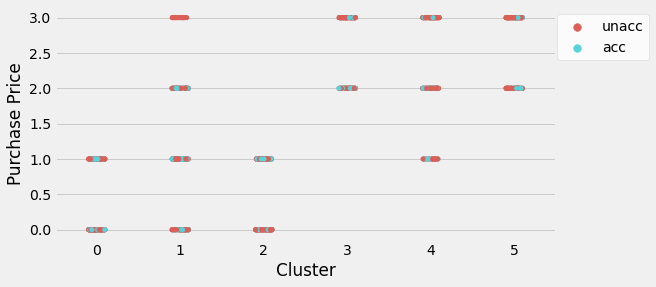

In [20]:
# using swarm plots to visualize clusters
plt.figure(figsize=(8,4))
sns.stripplot(x="Cluster", y="Purchase Price", hue="New Rating", palette="hls", jitter=True, data=df_results);
plt.legend(facecolor="white", bbox_to_anchor=(1.2, 1))
plt.show()

Clusters 0-2 have more acceptable car ratings in low-medium price range. Clusters 3-5 have more acceptable car ratings in the medium-high range.

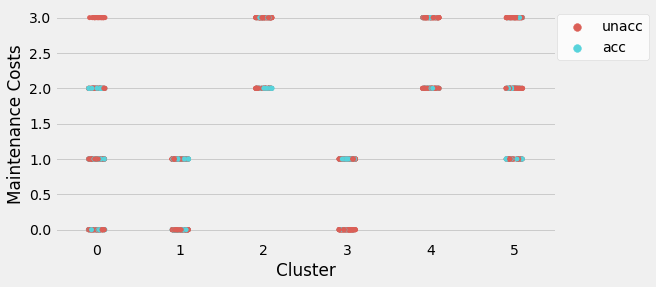

In [21]:
# using swarm plots to visualize clusters
plt.figure(figsize=(8,4))
sns.stripplot(x="Cluster", y="Maintenance Costs", hue="New Rating", palette="hls", jitter=True, data=df_results);
plt.legend(facecolor="white", bbox_to_anchor=(1.2, 1))
plt.show()

Clusters 0-1 and 3 have more acceptable car ratings due to low-high maintenance costs. Clusters 4-5 have fewer acceptable car ratings because most vehicles have high-very high maintenance costs. 

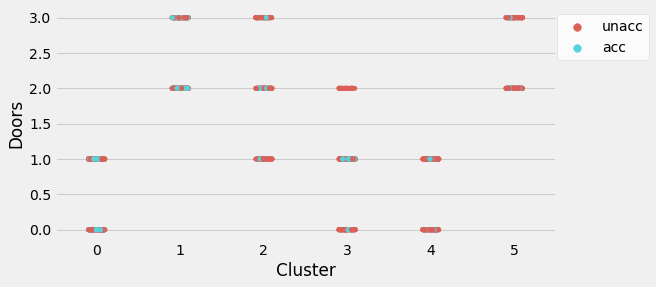

In [22]:
# using swarm plots to visualize clusters
plt.figure(figsize=(8,4))
sns.stripplot(x="Cluster", y="Doors", hue="New Rating", palette="hls", jitter=True, data=df_results);
plt.legend(facecolor="white", bbox_to_anchor=(1.2, 1))
plt.show()

The doors clusters do not indicate any useful insights. The patterns seem to be all over the place.

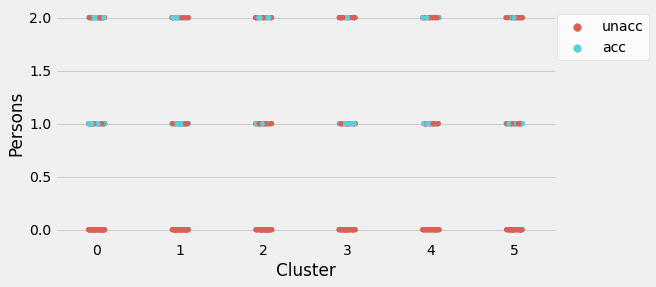

In [23]:
# using swarm plots to visualize clusters
plt.figure(figsize=(8,4))
sns.stripplot(x="Cluster", y="Persons", hue="New Rating", palette="hls", jitter=True, data=df_results);
plt.legend(facecolor="white", bbox_to_anchor=(1.2, 1))
plt.show()

All clusters have a high number of unacceptable car ratings for two person vehicles. On the contrast, all of them have a good amount of vehicles with acceptable car ratings for four person or more than four person vehicles.

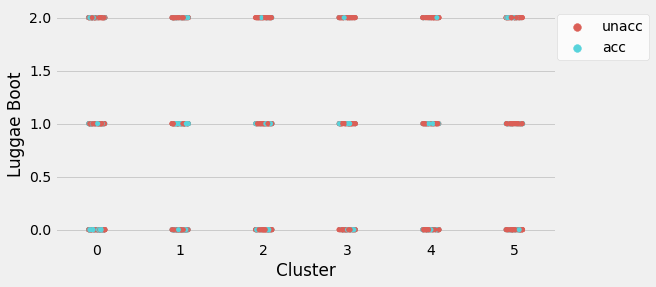

In [24]:
# using swarm plots to visualize clusters
plt.figure(figsize=(8,4))
sns.stripplot(x="Cluster", y="Luggae Boot", hue="New Rating", palette="hls", jitter=True, data=df_results);
plt.legend(facecolor="white", bbox_to_anchor=(1.2, 1))
plt.show()

The first two cluster have more acceptable car ratings for low-medium luggage vehicles.

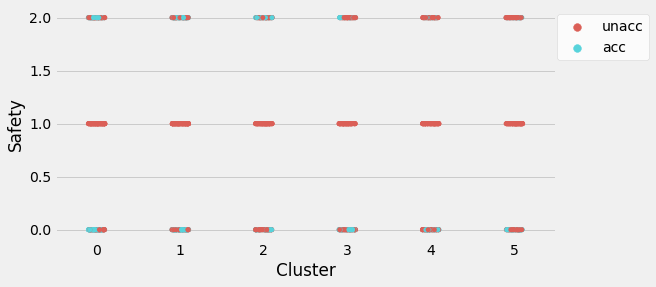

In [25]:
# using swarm plots to visualize clusters
plt.figure(figsize=(8,4))
sns.stripplot(x="Cluster", y="Safety", hue="New Rating", palette="hls", jitter=True, data=df_results);
plt.legend(facecolor="white", bbox_to_anchor=(1.2, 1))
plt.show()

Cluster 0-2 have a lot of acceptable car ratings for high safe vehicles. However, there are many acceptable car ratings for low safe vehicles across all cluster. I wonder if their associated with another feature we have seen?

Two features that might be interesting from a business perspective are purchase price and maintenance costs. The purchase price variable has an even number of clusters with a high amount of acceptable car ratings in different price ranges. Clusters 0-2 have many acceptable car ratings from low-mid purchase prices, while clusters 3-5 have many from high-very high purchase prices. For maintenance costs, clusters with low-medium costs have more acceptable car ratings. These feature patterns are easy to identify separately using stripplots.

### K-Nearest Neighbors Classification

The objective with a K-Nearest Neighbor classifier is to determine accuracy, precision, recall, and f1 scores for the target **"ratings"**.

In [26]:
# importing scikit-learn packages for KNeighbors classifier model
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline

In [27]:
# features
X = car_data.iloc[:, :-1]
print(X.shape)

# target
y = car_data.Rating
print(y.shape)

(1728, 6)
(1728,)


Splitting the data into traning and testing for a final holdout validation set.
20% will be used for the testing set.

In [28]:
# splitting the data using K-Folds Cross Validation
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.2, random_state=1, shuffle=True)
print("X_train:", len(X_train), "X_test:", len(X_test),
      "y_train:", len(X_train), "y_test:", len(X_test))

X_train: 1382 X_test: 346 y_train: 1382 y_test: 346


In [29]:
# creating Simple Imputer, OneHot Encoder, and Standard Scaler objects
constant_imp = SimpleImputer(strategy="most_frequent")
ohe = OneHotEncoder(handle_unknown="ignore")

In [30]:
# creating pipeline for categorical variable transformations
imp_ohe = make_pipeline(constant_imp, ohe)

In [31]:
# transforming variables using a column transformer
ct_imputer = make_column_transformer(
    (imp_ohe, X.columns)
)

In [32]:
# creating an instance of knn classifier
knn = KNeighborsClassifier(n_neighbors=3)

In [33]:
# creating a pipeline
pipe = make_pipeline(ct_imputer, knn)
pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['Purchase Price', 'Maintenance Costs', 'Doors', 'Persons',
       'Luggae Boot', 'Safety'],
      dtype='object'))])),
                ('kneighborsclassifier', KNeighborsClassifier(n_neighbors=3))])

In [34]:
# using cross val score function to test model accuracy
from sklearn.model_selection import cross_val_score
round(cross_val_score(pipe, X, y, cv=5, scoring="f1_macro").mean(), 3)

0.635

In [35]:
# retrieving named steps in the pipeline
pipe.named_steps.keys()

dict_keys(['columntransformer', 'kneighborsclassifier'])

Two important parameters than can use tuning are:
- number of neighbors
- weights  

The max number of neighbors will be 25. Weights can only uniform or distance measurements.

In [36]:
# grid parameter values
params = {
    "kneighborsclassifier__n_neighbors": np.arange(1, 25),
    "kneighborsclassifier__weights": ["uniform", "distance"]
}

In [37]:
# creating grid search CV instance
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(pipe, params, cv=5, scoring="f1_macro")
grid.fit(X, y);

In [38]:
# displaying grid search results
results = pd.DataFrame(grid.cv_results_).sort_values("rank_test_score").reset_index(drop=True)[:10]
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_kneighborsclassifier__n_neighbors,param_kneighborsclassifier__weights,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.006783,0.000399,0.018150,0.000400,12,distance,"{'kneighborsclassifier__n_neighbors': 12, 'kne...",0.786045,0.737006,0.767225,0.844242,0.704614,0.767827,0.047153,1
1,0.006385,0.000486,0.018754,0.000403,13,distance,"{'kneighborsclassifier__n_neighbors': 13, 'kne...",0.754643,0.790226,0.756598,0.791901,0.695353,0.757744,0.035001,2
2,0.006183,0.000398,0.025132,0.000399,12,uniform,"{'kneighborsclassifier__n_neighbors': 12, 'kne...",0.771040,0.733430,0.774240,0.782398,0.704614,0.753145,0.029546,3
3,0.006377,0.000481,0.017952,0.000631,14,distance,"{'kneighborsclassifier__n_neighbors': 14, 'kne...",0.752403,0.727921,0.752788,0.819498,0.677825,0.746087,0.045747,4
4,0.006779,0.000400,0.024846,0.000171,11,uniform,"{'kneighborsclassifier__n_neighbors': 11, 'kne...",0.813639,0.717353,0.747684,0.803905,0.637493,0.744015,0.064040,5
5,0.006383,0.000489,0.018350,0.000489,11,distance,"{'kneighborsclassifier__n_neighbors': 11, 'kne...",0.821604,0.714987,0.740662,0.803905,0.637493,0.743730,0.066041,6
6,0.006582,0.000489,0.018949,0.000002,16,distance,"{'kneighborsclassifier__n_neighbors': 16, 'kne...",0.689194,0.714415,0.748547,0.850866,0.701585,0.740921,0.058432,7
7,0.006279,0.000397,0.027932,0.006993,10,uniform,"{'kneighborsclassifier__n_neighbors': 10, 'kne...",0.731049,0.759185,0.733332,0.750825,0.708438,0.736566,0.017590,8
8,0.006582,0.000489,0.018351,0.000487,10,distance,"{'kneighborsclassifier__n_neighbors': 10, 'kne...",0.728632,0.759185,0.733332,0.750825,0.708438,0.736082,0.017767,9
9,0.006781,0.000398,0.018159,0.000399,15,distance,"{'kneighborsclassifier__n_neighbors': 15, 'kne...",0.719335,0.710883,0.753344,0.796121,0.678841,0.731705,0.039997,10


Twelve neighbors produces the highest mean f1 score (0.77) using distance as the weight.

In [39]:
# predicting target probabilities
pred_probs = grid.predict_proba(X_test)

In [40]:
# predicting target
pred_out = grid.predict(X_test)

In [41]:
# importing scikitplot for machine learning evaluation metrics
import scikitplot as skplt

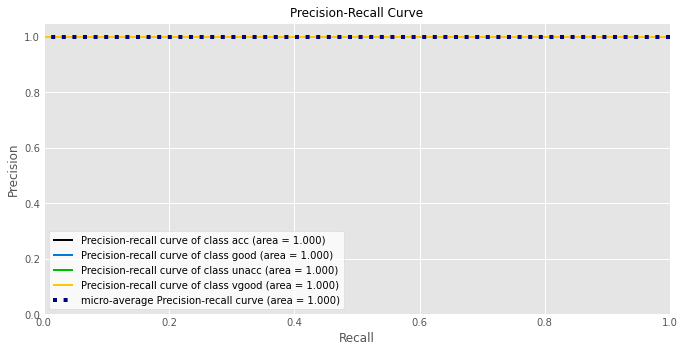

In [42]:
# plotting precision and recall curves
plt.style.use("ggplot")
skplt.metrics.plot_precision_recall(y_test, pred_probs, figsize=(10,5))
plt.legend(facecolor="white")
plt.show()

The model seems to overfit the data. This is probably from due to only training the model using ordinal features. Let's look at an ROC curve and confusion matrix to confirm these results.

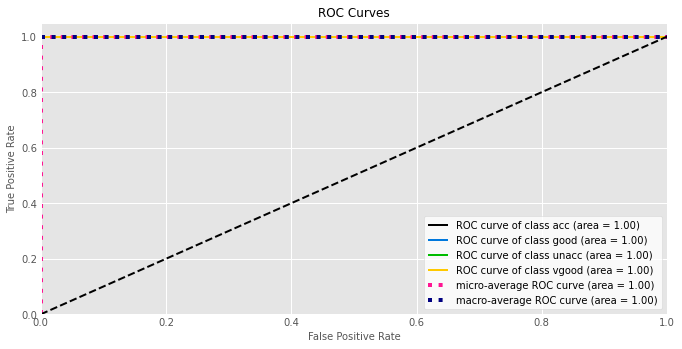

In [43]:
# plotting ROC curves
plt.style.use("ggplot")
skplt.metrics.plot_roc(y_test, pred_probs, figsize=(10,5))
plt.legend(facecolor="white")
plt.show()

As expected, the roc curves indicated the model is overfitting the data.

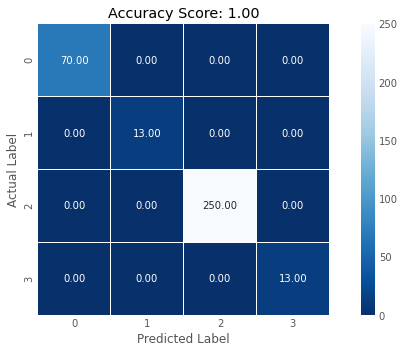

In [44]:
# creating confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, pred_out)

# creating figure and plotting heatmap
plt.figure(figsize=(10,5))
sns.heatmap(cm, annot=True, fmt=".2f", linewidths=.5, square=True,  cmap="Blues_r");
plt.ylabel("Actual Label");
plt.xlabel("Predicted Label");
plt.title("Accuracy Score: {:.2f}".format(round((np.trace(cm)) / (np.sum(cm)),2)));

In [45]:
# importing evaluation metrics and itertool
from sklearn.metrics import precision_recall_fscore_support
import itertools

# creating lists containing scores and names
score_results = list(precision_recall_fscore_support(y_test, pred_out, average="macro"))
score_names = ["precision", "recall", "fscore", "support"]

# looping through both lists and printing elements
for (score, name) in zip(score_results, score_names):
    if score != None:
        print(name, ": ", round(score, 2))
    else:
        print(name, ": ", score)

precision :  1.0
recall :  1.0
fscore :  1.0
support :  None


All scores are perfect signalling a high chance of overfitting.

The model is probably overfitting the data. My guess is the fixed amount of values in the ordinal variables make it easy for the model to memorize all future outcomes. An ideal solution might be to convert some of the ordinal variables to quantitative to reducing the chance of memorization.